# Bon Appetit - Recruit Restaurant Visitor Forecasting
*Mihwa Han (Mar 2018)*
___

<img src="img/restaurant.jpg">

A long-time dream of mine is to run my own restaurant. I like to imagine introducing people to many unique recipes in a beautiful setting, and making people happy after a difficult day. 
After all, enjoying delicious food in the right environment can erase many of your troubles.
Many people likely have similar goals, but operating your own restaurant presents many difficult challenges. 

Maintaining an efficient operation requires an accurate forecast of how many customers you expect each day in your restaurant. You need to know how many staff members to have on hand, and how much food to prepare, which depends on how many customers you will see that day. However, the number of customers that visit your restaurant might depend on many factors, like the weather, nearby competitors, and local events.

In this posting, I will use data from Recruit Holdings (via [Kaggle](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting#timeline)), which includes visitor counts for hundreds of restaurants in Japan and relevent information about those restaurants.
Specifically, Recruit Holdings owns <font color='green'>Hot Pepper Gourmet</font> (a restaurant review service), <font color='green'>AirREGI</font>(a restaurant point of sales service), and Restaurant Board (reservation log management software). I will use these data to predict the number of visitors to the restaurants on future dates.
**This information will help restaurants be much more efficient and allow them to focus on creating an enjoyable dining experience for their customers**. 

</n>
## 0. Quick Overview with Tableau
___

The plots below provides a simple overview of the data which includes location, genre, popular hours, and counts grouped by genre. I plotted all of the following using [Tableau](https://www.tableau.com/).
<img src="img/tableau.png">

</n>
## 1. Load  Libraries & the data
___

In [1]:
import glob, re
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd
from sklearn import *
from datetime import datetime
import h2o 
import scipy.stats as st
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

/Users/ryan/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/ryan/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/ryan/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  

In [2]:
air_visit = pd.read_csv('../input/air_visit_data.csv')
air_store = pd.read_csv('../input/air_store_info.csv')
hpg_store = pd.read_csv('../input/hpg_store_info.csv')
air_reserve = pd.read_csv('../input/air_reserve.csv')
hpg_reserve = pd.read_csv('../input/hpg_reserve.csv')
store_id = pd.read_csv('../input/store_id_relation.csv')
holiday = pd.read_csv('../input/date_info.csv').rename(columns={'calendar_date':'visit_date'})
sub = pd.read_csv('../input/sample_submission.csv')

For these various dataframes, the meaning of the variables is given on the [competition home page](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting/data). 
- **air_reserve.csv, hpg_reserve.csv**: reservations made in the air (*AirREGI*) or hpg (*Hot Pepper Gourmet*) systems
- **air_store_info.csv, hpg_store_info.csv**: information about *air* and *hpg* restaurants
- **store_id_relation.csv**: link the restaurants ids of the air and hpg systems
- **air_visit_data.csv**: historical visit data for the air restaurants
- **date_info.csv**: information about the calendar dates in the dataset


## 2. Overview: File structure 
___

### 2.1 Air Store Location
___

Where are the stores located? The code below comes from FabrienDaniel's kernel from Kaggle ([Here](https://www.kaggle.com/fabiendaniel/recruit-restaurant-eda))


Text(0.5,1.05,'air store restaurant locations')

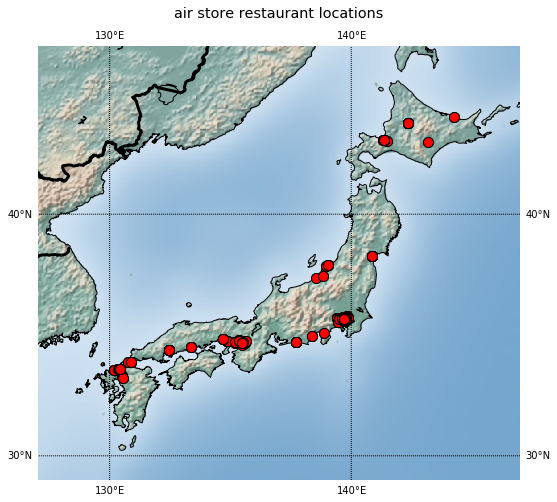

In [3]:
plt.figure(figsize=(15,8))
map = Basemap(resolution='i', llcrnrlon=127, urcrnrlon=147, 
              llcrnrlat=29, urcrnrlat=47, lat_0=0, lon_0=0,)
map.shadedrelief()
map.drawcoastlines()
map.drawcountries(linewidth = 3)
map.drawstates(color='0.3')
parallels = np.arange(0.,360,10.,)
map.drawparallels(parallels, labels = [True for s in range(len(parallels))])
meridians = np.arange(0.,360,10.,)
map.drawmeridians(meridians, labels = [True for s in range(len(meridians))])
for index, (y,x) in air_store[['latitude','longitude']].iterrows():
    x, y = map(x, y)
    map.plot(x, y, marker='o', markersize = 10, 
             markeredgewidth = 1, color = 'red',markeredgecolor='k')
plt.title('air store restaurant locations', y = 1.05)

In [4]:
air_store.head(1)

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852


In [5]:
hpg_store.head(1)

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


Let's look at the distributions of genres for these restaurants:

Text(0,0.5,'Number')

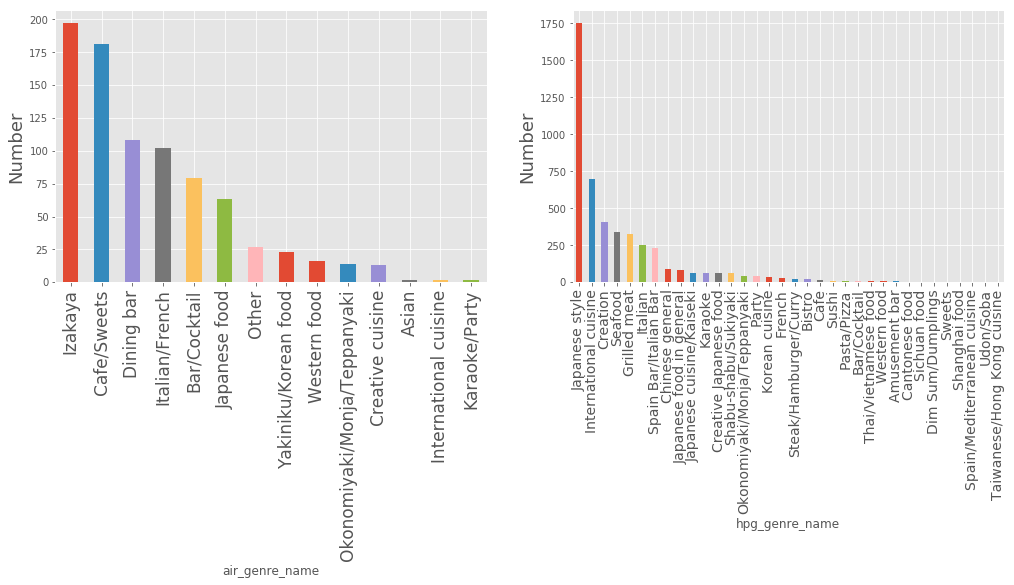

In [6]:
fig = plt.figure(figsize=(17,5))
ax = fig.add_subplot(121)
temp = air_store.groupby("air_genre_name").count()['air_store_id'].sort_values(ascending=False)
temp.plot(kind='bar',width=0.5,ax=ax)
ax.set_xticklabels(temp.sort_values(ascending=False).index,fontsize=17)
plt.ylabel("Number",fontsize=18)

ax = fig.add_subplot(122)
temp = hpg_store.groupby("hpg_genre_name").count()['hpg_store_id'].sort_values(ascending=False)
temp.plot(kind='bar',width=0.5,ax=ax)
ax.set_xticklabels(temp.sort_values(ascending=False).index,fontsize=14)
plt.ylabel("Number",fontsize=18)

In [7]:
print("Total Number of unique locations (Air): {}".format(len(air_store.
                                                              groupby("air_area_name").
                                                              count())))
print("Total Number of unique locations (HPG): {}".format(len(hpg_store.
                                                              groupby("hpg_area_name").
                                                              count())))

Total Number of unique locations (Air): 103
Total Number of unique locations (HPG): 119


### 2.2 Air Visits
___
Here I plot the total visitors and average visitors per day for all stores. 

In [8]:
air_visit.head(1)

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25


In [9]:
air_visit['visit_date']=pd.to_datetime(air_visit['visit_date'])

Text(0,0.5,'Ave(visitors)')

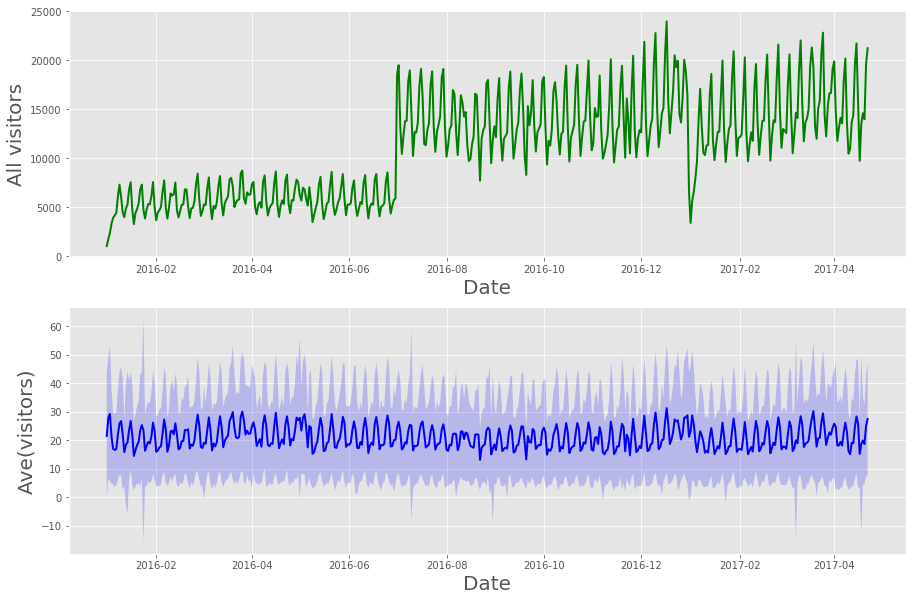

In [10]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
temp = air_visit.groupby(['visit_date']).sum()
ax1.plot(temp,'green',linewidth=2)
ax1.set_xlabel('Date',fontsize=20)
ax1.set_ylabel('All visitors',fontsize=20)

ax2 = fig.add_subplot(212)
temp = air_visit.groupby(['visit_date']).mean()
ax2.plot(temp.index,temp.values,'blue',linewidth=2)
error = air_visit.groupby(['visit_date']).std()
ax2.fill_between(temp.index,(temp.values-error.values).T[0], (temp.values+error.values).T[0],
                facecolor='blue', alpha=0.2)
ax2.set_xlabel('Date',fontsize=20)
ax2.set_ylabel('Ave(visitors)',fontsize=20)

I find:
- There is a large difference between total visitors before "2016-07" and after "2016-07". However, average number of visitors are similar based on the bottom figure. Why? Maybe there were new stores opening 2016-07?

In [11]:
print("Total Number of Restaurants : {}".format(len(air_visit.groupby("air_store_id").
                                                    count())))

Total Number of Restaurants : 829


Now let's group by month, and by day of the week, and examine trends in number of visitors.

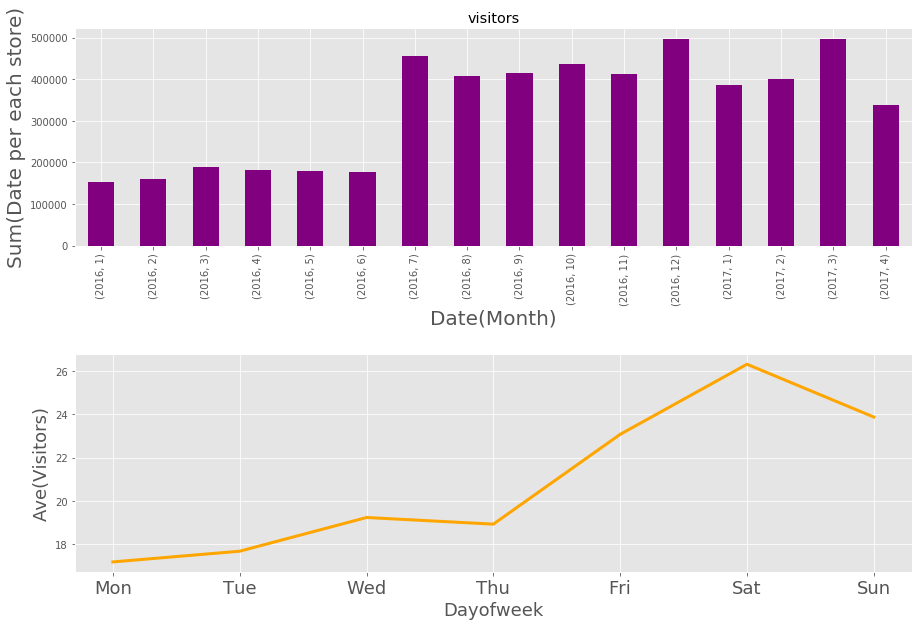

In [12]:
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(211)
t = air_visit.groupby([(air_visit.visit_date.dt.year), 
                       (air_visit.visit_date.dt.month)]).sum()['visitors']
t.plot(kind='bar', width=0.5, figsize=(10,5), legend=None, 
       subplots=True, ax=ax1, title=None, color='purple')
plt.xlabel("Date(Month)", fontsize=20)
plt.ylabel("Sum(Date per each store)", fontsize=20)

ax2 = fig.add_subplot(212)
air_visit["dayofweek"] = air_visit.visit_date.dt.dayofweek
day_p=air_visit.groupby("dayofweek").mean()['visitors']
day_p.plot(kind='line', color='orange', figsize=(10,5), legend=None, 
           subplots=True, ax=ax2, use_index=False, linewidth=3)
#plt.ylim(15,25)
plt.ylabel("Ave(Visitors)",fontsize=18)
plt.xlabel("Dayofweek",fontsize=18)
ax2.set_xticklabels(['','Mon','Tue','Wed','Thu','Fri','Sat','Sun'],fontsize=18)
plt.subplots_adjust(wspace=0.1, hspace=0.5)

Keeping in mind that the goal of this competition is to predict the number of visitors from April 23rd through May 31st in 2017, here's the number of visitors for that period in 2016:

Text(0,0.5,'Ave(Visitors)')

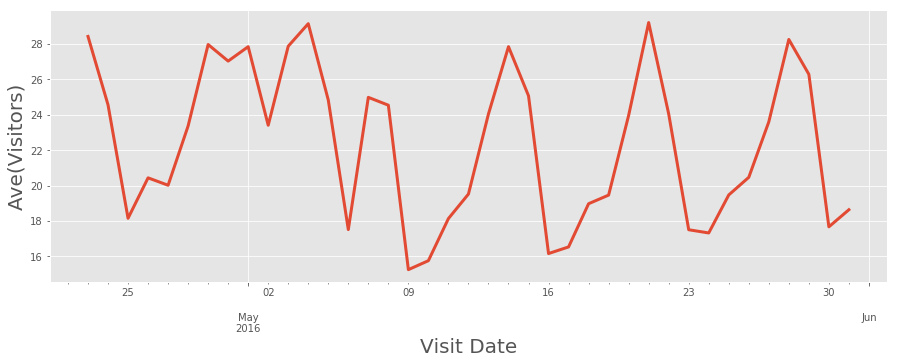

In [13]:
sub1 = air_visit[(air_visit.visit_date >= '2016-04-23') & 
                 (air_visit.visit_date <= '2016-05-31')]
temp = sub1.groupby(['visit_date']).mean()[['visitors','dayofweek']]
temp['visitors'].plot(kind='line', figsize=(15,5), legend=None, title=None, linewidth=3)
plt.xlabel("Visit Date", fontsize=20)
plt.ylabel("Ave(Visitors)", fontsize=20)

### 2.3 Air Reservations & Hpg Reservations
___

In [14]:
air_reserve.head(1)

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1


In [15]:
hpg_reserve.head(1)

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1


Make some features, like the hour of the reservations and visits.

In [16]:
air_reserve['visit_datetime']=pd.to_datetime(air_reserve['visit_datetime'])
air_reserve['reserve_datetime']=pd.to_datetime(air_reserve['reserve_datetime'])
air_reserve['visit_hour']=air_reserve['visit_datetime'].dt.hour
air_reserve['reserve_hour']=air_reserve['reserve_datetime'].dt.hour

hpg_reserve['visit_datetime']=pd.to_datetime(hpg_reserve['visit_datetime'])
hpg_reserve['reserve_datetime']=pd.to_datetime(hpg_reserve['reserve_datetime'])
hpg_reserve['visit_hour']=hpg_reserve['visit_datetime'].dt.hour
hpg_reserve['reserve_hour']=hpg_reserve['reserve_datetime'].dt.hour

(0, 730000)

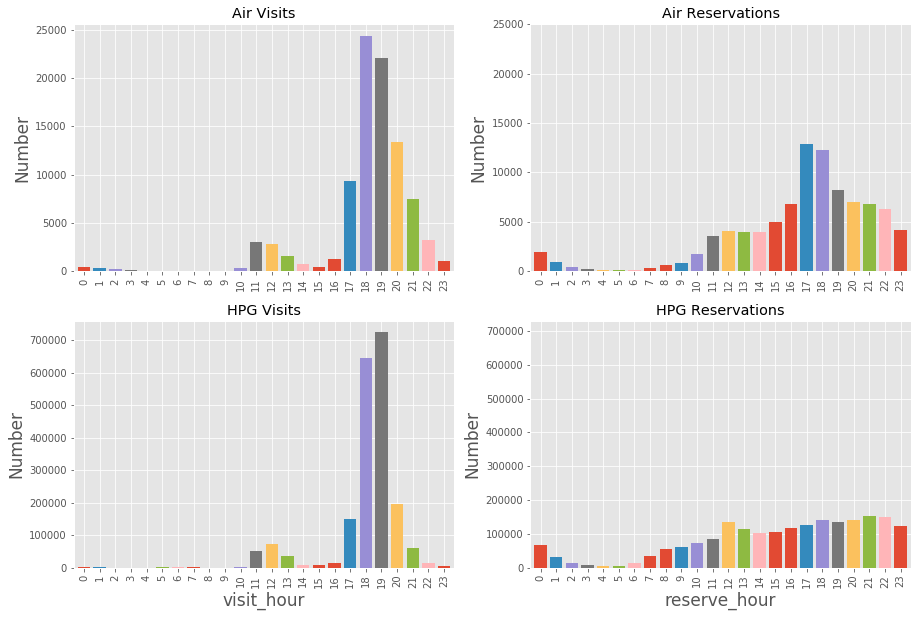

In [17]:
fig = plt.figure(figsize=(15,10))
ax=fig.add_subplot(221)
air_reserve.groupby("visit_hour").count()['reserve_visitors'].plot(kind='bar', 
                                                                   width=0.8, 
                                                                   ax=ax)
plt.xlabel("",fontsize=17)
plt.ylabel("Number",fontsize=17)
plt.title("Air Visits")

ax2=fig.add_subplot(222)
air_reserve.groupby("reserve_hour").count()['reserve_visitors'].plot(kind='bar', 
                                                                     width=0.8, 
                                                                     ax=ax2)
plt.xlabel("",fontsize=17)
plt.ylabel("Number",fontsize=17)
plt.title("Air Reservations")
plt.ylim(0,25000)

ax3=fig.add_subplot(223)
hpg_reserve.groupby("visit_hour").count()['reserve_visitors'].plot(kind='bar', 
                                                                   width=0.8, 
                                                                   ax=ax3)
plt.xlabel("visit_hour",fontsize=17)
plt.ylabel("Number",fontsize=17)
plt.title("HPG Visits")

ax4=fig.add_subplot(224)
hpg_reserve.groupby("reserve_hour").count()['reserve_visitors'].plot(kind='bar', 
                                                                     width=0.8, 
                                                                     ax=ax4)
plt.xlabel("reserve_hour",fontsize=17)
plt.ylabel("Number",fontsize=17)
plt.title("HPG Reservations")
plt.ylim(0,730000)

I find a bimodal distribution of visit hours, with the two peaks corresponding to lunch and dinner. The hours in which reservations are placed are more evenly-distributed, but in the case of Air reservations there is a notable peak in the late afternoon.

### 2.4 Holiday

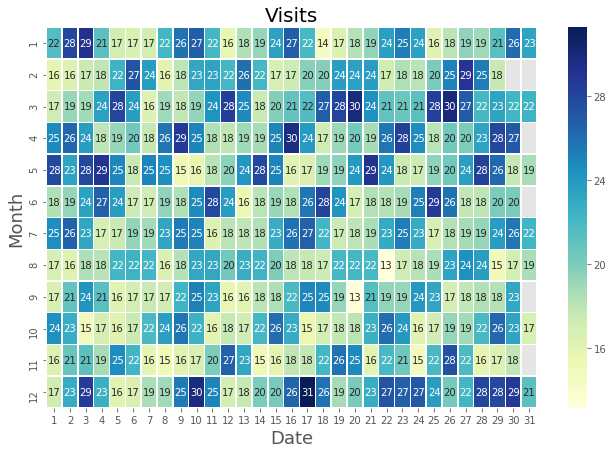

In [18]:
holiday['visit_date'] = pd.to_datetime(holiday['visit_date'])
holiday['month'] = holiday['visit_date'].dt.month 
holiday['date'] = holiday['visit_date'].dt.day

holiday['sunday'] = holiday['visit_date'].dt.dayofweek.apply(lambda x:1 if x==6 else 0)
holiday['saturday'] = holiday['visit_date'].dt.dayofweek.apply(lambda x:1 if x==5 else 0)
holiday['sat/sun/hol']=holiday['holiday_flg']*1+holiday['sunday']*0.5+holiday['saturday']*0.3

holiday2016 = holiday[holiday['visit_date'].dt.year==2016]
holiday2017 = holiday[holiday['visit_date'].dt.year==2017]

air_visit['month'] = air_visit['visit_date'].dt.month 
air_visit['date'] = air_visit['visit_date'].dt.day
air_visit2016 = air_visit[air_visit['visit_date'].dt.year==2016]
air_visit2017 = air_visit[air_visit['visit_date'].dt.year==2017]

holiday['sat/sun/hol']=holiday['holiday_flg']*1+holiday['sunday']*0.5+holiday['saturday']*0.3

tb1=pd.pivot_table(holiday2016,values='sat/sun/hol',index=['month'],columns=['date'])
tb2=pd.pivot_table(air_visit2016,values='visitors',index=['month'],columns=['date'])

fig=plt.figure(figsize=(22,7))
 

ax2 = fig.add_subplot(122)
sns.heatmap(tb2,annot=True, cmap="YlGnBu",linewidths='0.5',ax=ax2)
plt.title("Visits",fontsize=20)
plt.xlabel("Date",fontsize=18)
plt.ylabel("Month",fontsize=18)
fig.subplots_adjust(wspace=0.001)

The figures above show 2016 calendars (month on the y-axis and day of the month on the x-axis). The left calendar shows each day color coded, with light yellow being non-holiday weekdays. Non-holiday Saturdays and Sundays are colored light and darker green, respectively. Holidays are given different shades of blue, depending on whether they are weekdays (lighter) or Saturdays or Sundays (progressively darker).

The figure on the right shows the 2016 calendar, with each cell showing the average number of visitors across all restaurants on that day, and the cells are color-coded from light-to-dark based on the number of visitors. You can see that the colors in these two calendars are correlated, overall, meaning that the weekends and holidays are the busiest times for these restaurants (with the notable exception of the holiday in mid-August).

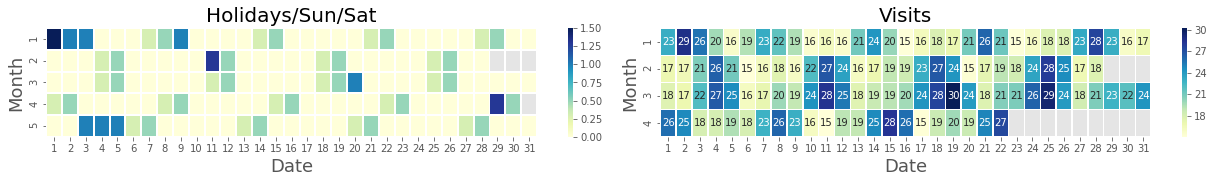

In [19]:
tb1=pd.pivot_table(holiday2017,values='sat/sun/hol',index=['month'],columns=['date'])
tb2=pd.pivot_table(air_visit2017,values='visitors',index=['month'],columns=['date'])

fig=plt.figure(figsize=(22,2))
ax1 = fig.add_subplot(121)
sns.heatmap(tb1,cmap="YlGnBu",linewidths='1',ax=ax1)
plt.title("Holidays/Sun/Sat",fontsize=20)
plt.xlabel("Date",fontsize=18)
plt.ylabel("Month",fontsize=18)

ax2 = fig.add_subplot(122)
sns.heatmap(tb2,annot=True, cmap="YlGnBu",linewidths='0.5',ax=ax2)
plt.title("Visits",fontsize=20)
plt.xlabel("Date",fontsize=18)
plt.ylabel("Month",fontsize=18)
fig.subplots_adjust(wspace=0.001)

The figures above show the same calendar as before, but for our data in 2017.

## 3. RandomForest

For Machine learning, we need to do feature engineering. The following feature engineering steps, and the modeling, come from a couple of popular kernels in the Kaggle competition: [This Kernel](https://www.kaggle.com/tunguz/surprise-me-2/code) and [This Kernel](https://www.kaggle.com/yekenot/explore-ts-with-lstm). To make this all much cleaner, I have wrapped up all the feature engineering steps into a separate function that is called below.

In [55]:
air_visit = pd.read_csv('../input/air_visit_data.csv')
air_store = pd.read_csv('../input/air_store_info.csv')
hpg_store = pd.read_csv('../input/hpg_store_info.csv')
air_reserve = pd.read_csv('../input/air_reserve.csv')
hpg_reserve = pd.read_csv('../input/hpg_reserve.csv')
store_id = pd.read_csv('../input/store_id_relation.csv')
holiday = pd.read_csv('../input/date_info.csv').rename(columns={'calendar_date':'visit_date'})
sub = pd.read_csv('../input/sample_submission.csv')

from feature_engineering import *
reserve=feature_engineering1(hpg_reserve,store_id,air_reserve)
air_visit,sub,air_store = feature_engineering2(air_visit,sub,air_store)

lbl = preprocessing.LabelEncoder()
holiday['visit_date'] = pd.to_datetime(holiday['visit_date'])
holiday['day_of_week'] = lbl.fit_transform(holiday['day_of_week'])

train = pd.merge(air_visit, holiday, how='left', on=['visit_date']) 
test = pd.merge(sub, holiday, how='left', on=['visit_date']) 
train.drop(['latitude','longitude','air_genre_name','air_area_name'], axis=1, inplace=True)
test.drop(['latitude','longitude','air_genre_name','air_area_name'], axis=1, inplace=True)

reserve['visit_date'] = pd.to_datetime(reserve['visit_date'])
train = pd.merge(train, reserve, how='left', on=['air_store_id','visit_date']) 
test = pd.merge(test, reserve, how='left', on=['air_store_id','visit_date'])

col = [
    c for c in train
    if c not in ['id', 'air_store_id', 'visit_date', 'visitors']
]
train = train.fillna(-1)
test = test.fillna(-1)

for c, dtype in zip(train.columns, train.dtypes):
    if dtype == np.float64:
        train[c] = train[c].astype(np.float32)

for c, dtype in zip(test.columns, test.dtypes):
    if dtype == np.float64:
        test[c] = test[c].astype(np.float32)

X=train[col]
X_train = train[train.visit_date<'2017-03-01'][col]
X_test = train[train.visit_date>'2017-03-01'][col]

y_train = np.log1p(train[train.visit_date<'2017-03-01']['visitors'].values)
y_test = np.log1p(train[train.visit_date>'2017-03-01']['visitors'].values)

regr = RandomForestRegressor(max_depth=2, random_state=0)
rf_model = regr.fit(X_train, y_train)

pred=rf_model.predict(X_test)
print('RF Test RMSLE w/o new features: %.3f' % RMSLE(np.expm1(pred),np.expm1(y_test)))


RF Test RMSLE w/o new features: 0.789


## 4. Feature Engineering + Random Forest

In [56]:
stores = feature_engineering3(sub,air_visit)
train,test = feature_engineering4(holiday,air_visit,sub,reserve,stores)
train,test = feature_engineering5(train,test)

from model_rf import *
X,X_train,X_test,y_train,y_test = rf_prep(train,test)
model_rf = model_rf(X, X_train, X_test, y_train, y_test) 
rmsle_rf = model_rf_eval(model_rf,X_test,y_test)
print('RF Test RMSLE: %.3f' % rmsle_rf)

RF Test RMSLE: 0.555


## 5. Feature Engineering + XGBoost

Now try using eXtreme Gradient Boosted Trees.

In [31]:
from model_xgboost import *
X,X_train,X_valid,X_test,y_train,y_valid,y_test = xgb_prep(train,test)
xgb_params = {
        'eta': 0.05,
        'min_child_weight': 10,
        'n_trees': 10000, 
        'max_depth': 10,
        'subsample': 0.9,
        'colsample_bytree': 1,
        'objective': "reg:linear",
        'silent': 1}
xgb_model = model_xgb(X,X_train,X_valid,X_test,y_train,y_valid,y_test,xgb_params)

[0]	val-rmse:2.29756
Will train until val-rmse hasn't improved in 20 rounds.
[10]	val-rmse:1.42589
[20]	val-rmse:0.933033
[30]	val-rmse:0.670665
[40]	val-rmse:0.543434
[50]	val-rmse:0.486703
[60]	val-rmse:0.462008
[70]	val-rmse:0.449646
[80]	val-rmse:0.442986
[90]	val-rmse:0.439472
[100]	val-rmse:0.435711
[110]	val-rmse:0.432823
[120]	val-rmse:0.43122
[130]	val-rmse:0.43022
[140]	val-rmse:0.429182
[150]	val-rmse:0.429161
[160]	val-rmse:0.428974
[170]	val-rmse:0.428972
[180]	val-rmse:0.428972
Stopping. Best iteration:
[169]	val-rmse:0.428972



In [32]:
rmsle_xgboost = model_xgb_eval(xgb_model,X_test,y_test)
print('xgboost Test RMSLE: %.3f' % rmsle_xgboost)

xgboost Test RMSLE: 0.490


</n>
## 5. Conclusion
___

I have explored the data included in this challenge, which consists of geographic, categorical, and time-series visitor and reservation data for all 829 restaurants. All of these factors make for an extremely complicated data challenge, and the difficulty is greater because we have only slightly more than one year of data to work with (which makes seasonal effects hard to predict accurately). Furthermore, some of these restaurants first opened part-way through 2016, and so we lack even one full year of data for them.

The RMSLE of the baseline model (RandomForest Regressor) was 0.789. However, after adding some more features, like the average and standard deviation of number of visitors in each store, I trained an RandomForest Regressor and XGBoost Regressor to predict the number of visitors from April 23rd through May 31st in 2017. The RandomForest Regressor model achieves an RMSLE of 0.555, while XGBoost has a much improved RMSLE of 0.49, which was ~40% of an improvement.

## Most Important Factors

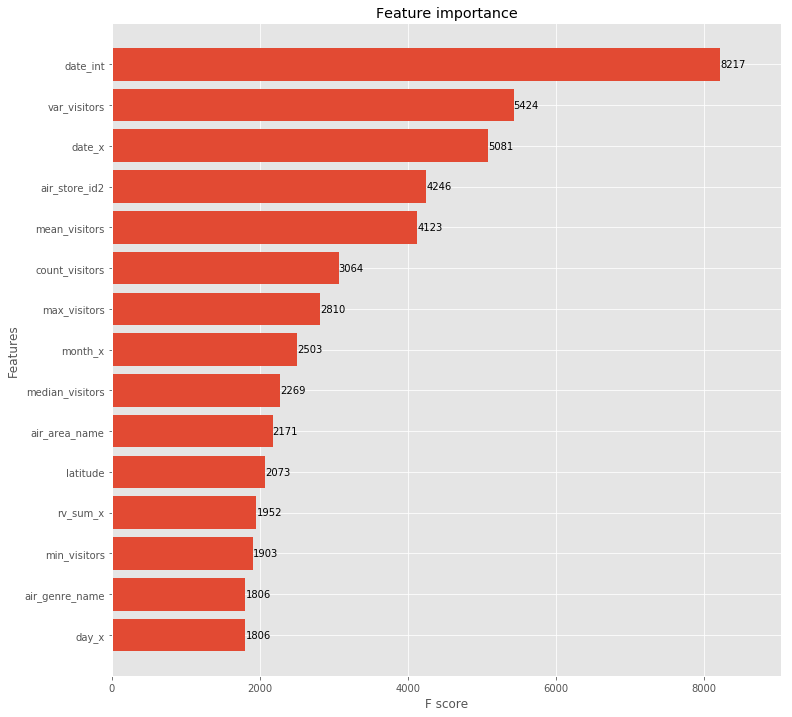

In [59]:
import xgboost as xgb
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(xgb_model, max_num_features=15, height=0.8, ax=ax)
plt.show()